<a href="https://colab.research.google.com/github/jonathanmendoza-tx/DS-Unit-2-Regression-Classification/blob/master/module3/Copy_of_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

## Load

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

     |████████████████████████████████| 92kB 9.1MB/s 
     |████████████████████████████████| 133kB 28.8MB/s 
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
     |████████████████████████████████| 614kB 49.4MB/s 
     |████████████████████████████████| 225kB 51.0MB/s 
     |████████████████████████████████| 768kB 38.1MB/s 
     |████████████████████████████████| 194kB 54.9MB/s 
     |████████████████████████████████| 51kB 28.1MB/s 
     |████████████████████████████████| 737kB 60.6MB/s 
     |████████████████████████████████| 51kB 28.9MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=97da625906adb1c64d681e8ca63d80d3bc1d5991fccaa11161568c665576ee88
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=b261f6205f357b8b227bc7626dd03717506fd781

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

## Explore

In [0]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np

In [5]:
print(df.shape)
df.head()

(23040, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [6]:
df.isna().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

In [0]:
df = df.drop(['EASE-MENT','APARTMENT_NUMBER'], axis = 1)

In [8]:
df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']
df['BUILDING_CLASS_CATEGORY'].value_counts()

01 ONE FAMILY DWELLINGS    5061
Name: BUILDING_CLASS_CATEGORY, dtype: int64

In [9]:
df.isna().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [10]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                    5061
unique                    119
top       2019-01-31 00:00:00
freq                       96
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [11]:
train = df[df['SALE_DATE'].dt.month < 4]
test = df[df['SALE_DATE'].dt.month == 4]

train.shape, test.shape

((4094, 19), (967, 19))

In [12]:
train = train.query('SALE_PRICE >= 100000 & SALE_PRICE <=2000000')
train.shape

(2517, 19)

In [13]:
train.dtypes

BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE                         datetime64[ns]
dtype: object

In [14]:
train['LAND_SQUARE_FEET'] = train['LAND_SQUARE_FEET'].str.replace(',','').astype('float64')
test['LAND_SQUARE_FEET'] = test['LAND_SQUARE_FEET'].str.replace(',','').astype('float64')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
train.nunique()

BOROUGH                              5
NEIGHBORHOOD                       178
BUILDING_CLASS_CATEGORY              1
TAX_CLASS_AT_PRESENT                 2
BLOCK                             2066
LOT                                304
BUILDING_CLASS_AT_PRESENT           13
ADDRESS                           2507
ZIP_CODE                           123
RESIDENTIAL_UNITS                    2
COMMERCIAL_UNITS                     3
TOTAL_UNITS                          4
LAND_SQUARE_FEET                   889
GROSS_SQUARE_FEET                  924
YEAR_BUILT                          86
TAX_CLASS_AT_TIME_OF_SALE            1
BUILDING_CLASS_AT_TIME_OF_SALE      11
SALE_PRICE                         882
SALE_DATE                           68
dtype: int64

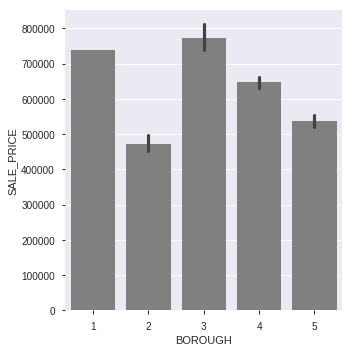

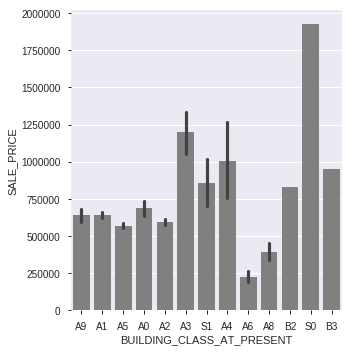

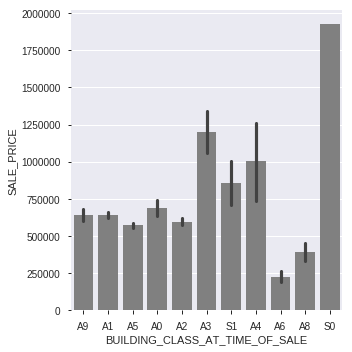

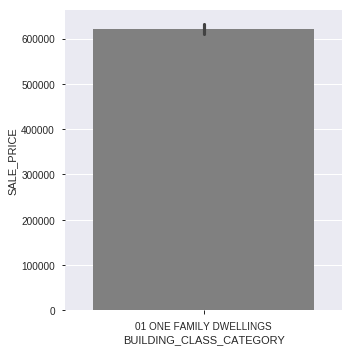

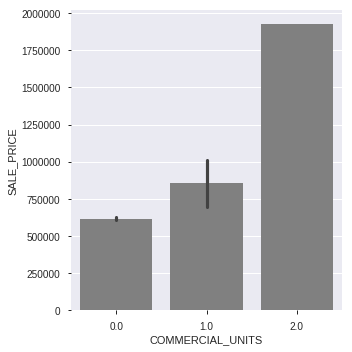

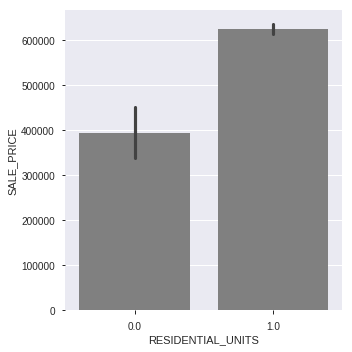

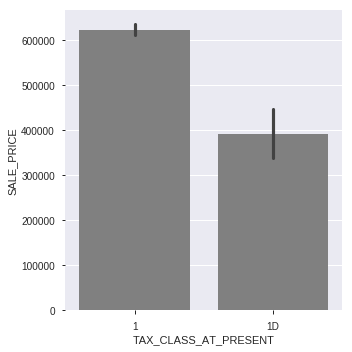

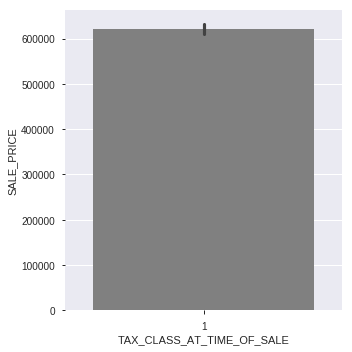

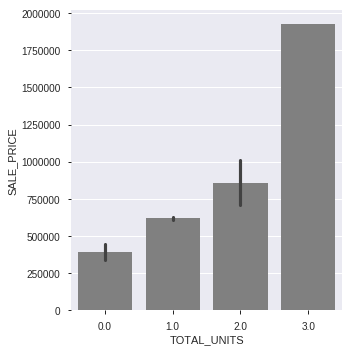

In [16]:
for col in sorted(train.columns):
  if train[col].nunique() <= 13:
    sns.catplot(x=col, y='SALE_PRICE', data = train, kind = 'bar', color = 'grey')
    plt.show()

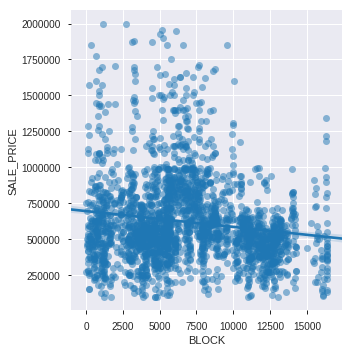

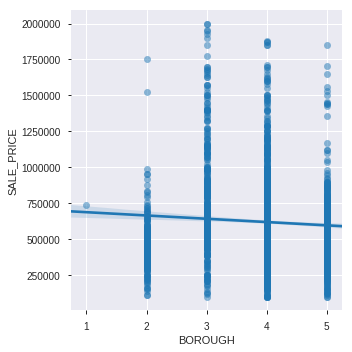

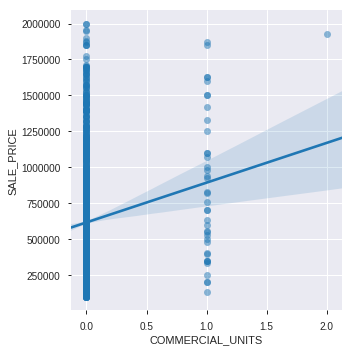

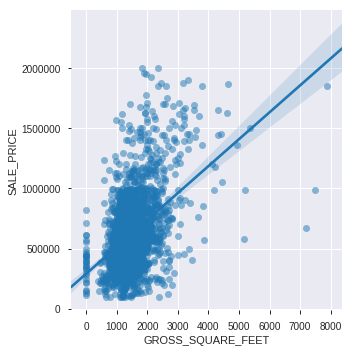

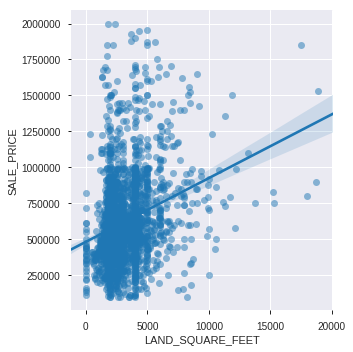

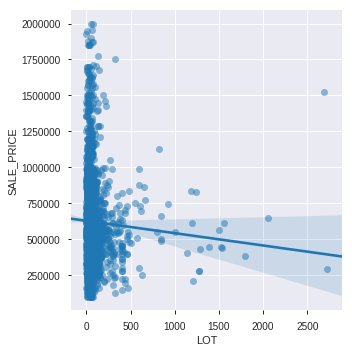

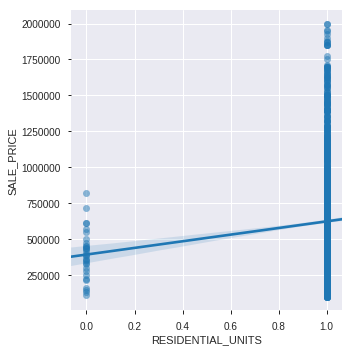

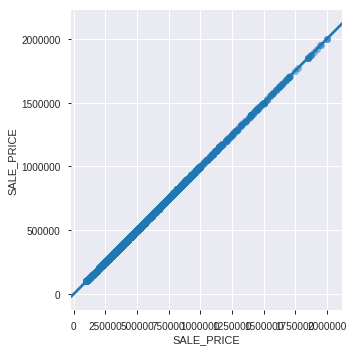

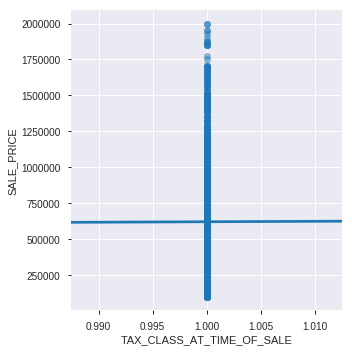

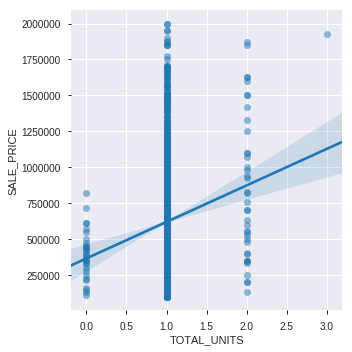

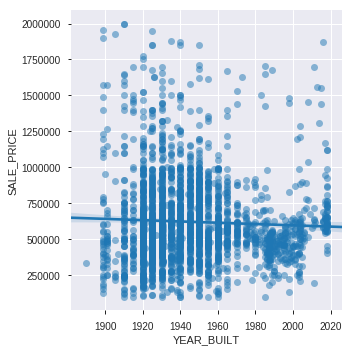

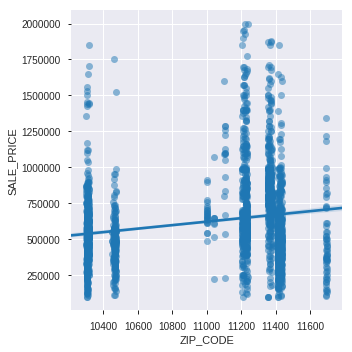

In [17]:
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y = 'SALE_PRICE', data = train, scatter_kws = dict(alpha=0.5))
    plt.show()

In [18]:
train.describe(exclude = 'number').T.sort_values(by = 'unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2517,1,01 ONE FAMILY DWELLINGS,2517,NaN,NaN
TAX_CLASS_AT_PRESENT,2517,2,1,2486,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2517,11,A1,921,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2517,13,A1,921,NaN,NaN
SALE_DATE,2517,68,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-30 00:00:00
NEIGHBORHOOD,2517,178,FLUSHING-NORTH,78,NaN,NaN
ADDRESS,2517,2507,117-45 125TH STREET,2,NaN,NaN


In [19]:
b_class_other = train['BUILDING_CLASS_AT_TIME_OF_SALE'].value_counts()[4:].index
b_class_other

Index(['A0', 'S1', 'A3', 'A8', 'A6', 'A4', 'S0'], dtype='object')

In [20]:
di = {b_class_other[n]:"other" for n in range(len(b_class_other))}
di

{'A0': 'other',
 'A3': 'other',
 'A4': 'other',
 'A6': 'other',
 'A8': 'other',
 'S0': 'other',
 'S1': 'other'}

In [0]:
def feature_modifier(df,feature, dictionary, new_feat):
  #returns a dataframe with a new column consisting of new values based on a dictionary
  df[new_feat] = df[feature].replace(dictionary)
  return df

In [35]:
train = feature_modifier(train,'BUILDING_CLASS_AT_TIME_OF_SALE',di,'building_class_modified')
test = feature_modifier(test,'BUILDING_CLASS_AT_TIME_OF_SALE',di,'building_class_modified')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
train['building_class_modified'].value_counts()

A1       921
A5       781
A2       416
other    205
A9       194
Name: building_class_modified, dtype: int64

In [37]:
train.groupby('building_class_modified')['SALE_PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
building_class_modified,,,,,,,,
A1,921.0,639882.487514,312379.716631,100000.0,450000.0,570000.0,772500.0,1955000.0
A2,416.0,595555.418269,246879.753773,100000.0,425000.0,551000.0,782500.0,1614600.0
A5,781.0,570596.308579,220638.261466,100000.0,435000.0,532000.0,688888.0,1775000.0
A9,194.0,638255.118557,291090.573816,115000.0,471250.0,583500.0,760000.0,2000000.0
other,205.0,763635.790244,458411.397034,100000.0,406282.0,650000.0,990000.0,2000000.0


In [0]:
train['BUILDING_CLASS_A1'] = np.where(train['building_class_modified']=='A1',1,0)
train['BUILDING_CLASS_A2'] = np.where(train['building_class_modified']=='A2',1,0)
train['BUILDING_CLASS_A5'] = np.where(train['building_class_modified']=='A5',1,0)
train['BUILDING_CLASS_A9'] = np.where(train['building_class_modified']=='A9',1,0)
train['BUILDING_CLASS_other'] = np.where(train['building_class_modified']=='other',1,0)

In [32]:
test['BUILDING_CLASS_A1'] = np.where(test['building_class_modified']=='A1',1,0)
test['BUILDING_CLASS_A2'] = np.where(test['building_class_modified']=='A2',1,0)
test['BUILDING_CLASS_A5'] = np.where(test['building_class_modified']=='A5',1,0)
test['BUILDING_CLASS_A9'] = np.where(test['building_class_modified']=='A9',1,0)
test['BUILDING_CLASS_other'] = np.where(test['building_class_modified']=='other',1,0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

## Analyze

In [33]:
train_subset = train.select_dtypes('number').dropna(axis = 'columns')
test_subset = test.select_dtypes('number').dropna(axis = 'columns')

target = 'SALE_PRICE'
features = train_subset.columns.drop(target)

X_train = train_subset[features]
y_train = train_subset[target]

X_test = test_subset[features]
y_test = test_subset[target]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2517, 16), (2517,), (967, 16), (967,))

In [42]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func = f_regression, k = 6)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((2517, 6), (967, 6))

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')

Test MAE: $398,406


In [44]:
import statsmodels.api as sm
X1 = sm.add_constant(X_train_selected)
result = sm.OLS(y_train, X1).fit()
print(result.rsquared, result.rsquared_adj)

0.39421157905534254 0.39276347924431954


##Stretch

In [90]:
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size = 0.8, test_size = 0.2
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2013, 16), (504, 16), (2013,), (504,))

In [0]:
X_train_numeric = X_train.select_dtypes('number')
X_val_numeric = X_val.select_dtypes('number')

In [93]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(n_jobs = -1)
model.fit(X_train_numeric, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [94]:
model.score(X_val_numeric, y_val)

0.015873015873015872

In [96]:
encoder = ce.OneHotEncoder(use_cat_names = True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

model.fit(X_train_scaled, y_train)

model.score(X_val_scaled, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.011904761904761904